In [1]:
from __future__ import division
from utils import *
from functions import *
from numba import autojit
%matplotlib inline

%load_ext autoreload
%autoreload 2

today = datetime.date.today()
todayStr = '%04d%02d%02d' % (today.year, today.month, today.day)
# todayStr = '20151005'
DIRECTORY = os.path.expanduser("~/Dropbox/0000 - PhD/figures/"+todayStr+"/")
if not os.path.exists(DIRECTORY):
    os.makedirs(DIRECTORY)

In [2]:
PAPER = os.path.expanduser('~/Dropbox/ICL-2014/Presentations/2016-10-11-GJ-sync-paper/figures/')

In [3]:
'''
SINGLE NEURON FREQUENCY RESPONSE
'''
T = 2000
dt = 1
t = np.arange(0,T,dt)
F = np.logspace(0.5,2.3,200)

@autojit
def resonance(F, model = 'cc'):
    res_var = np.empty(len(F), dtype=np.float64)
    b = 2
    for k,f in enumerate(F):
        A = 0.01
        I = A*np.cos(2*np.pi*f*t/1000)
        res_v = []
        res_u = []
        u=0
        t_rest=0
        if model == 'izh':
            v = -65
            for i in range(len(t)):
                v += dt/20 * ( (v+60)*(v+50) - 20000*u + 30*I[i])
                u += dt * 0.2 * ( 0.025 * (v +55)**3*(v>-55) - u)
                if v>25:
                    v = -45
                if i*dt>1500:
                    res_v.append(v/A)
        elif model == 'gp-izh':
            v = -60
            for i in range(len(t)):
                v += dt/15 * ( (v+60)*(v+50) - 20*u + 8*I[i])
                u += dt * 0.044 * ( (v +55) - u)
                if v>25:
                    v = -40
                    u += 50
                if i*dt>1500:
                    res_v.append(v/A)
        elif model == 'cc-tchu': 
            v = -65
            u = 0
            for i in range(len(t)):
                v += dt/100 * ( -v + -20*u + 30*I[i] );     
                u += dt/20 * ( -u + 4.5*v );
                if i*dt>1500:
                    res_v.append(v)
        elif model == 'TRN':
            v = -60
            for i in range(len(t)):
                v += dt/40 * ( 0.25*(v**2 + 110*v +45*65) - 2000*u + 0.01*I[i])
                u += dt * 0.015 * (b* (v +65) - u)
                if v>0:
                    v = -55
                    u += 50
                b = 10 * (v<-70) + 2*(v>=70)
                if i*dt>1500:
                    res_v.append(v/A)
        elif model == "IAF":
            v = 0
            for i in range(len(t)):
                if t[i] > t_rest:
                    v = v + (-v + I[i]*1) / 10 * dt
                if v >= 1:
                    v += 0.5
                    t_rest = t[i] + 4
                if i*dt>1500:
                    res_v.append(v/A)
            
        var = np.var(res_v)
#         var = np.max(res_v)-np.min(res_v)
        res_var[k] = var
    return res_var
# models = ['TRN','cc-izh', 'izh', 'mod1', 'cc-tchu']
models = ['gp-izh', 'cc-tchu']
# models = ['cc-tchu']
c = 0
# fig = plt.figure(figsize=(10,10))
# for model in models:
#     c+=1
#     ax = fig.add_subplot(110+1)
#     ax.semilogx(F, resonance(F, model))
#     ax.set_title('Inhibitory Response function '+model)
#     ax.set_ylabel('Response Function')
#     ax.set_xlabel('Frequency [Hz]')
# plt.tight_layout()
# plt.savefig(DIRECTORY + model +'_.pdf')

In [4]:
gp = resonance(F, 'gp-izh')
cc = resonance(F, 'cc-tchu')
izh = resonance(F, 'izh')
iaf = resonance(F, 'IAF')
x,y = readDataFile(os.path.expanduser('~/Dropbox/0000_PhD/post-ESA/FS.txt'))
x_rs,y_rs = readDataFile(os.path.expanduser('~/Dropbox/0000_PhD/post-ESA/RS.txt'))

In [5]:
print(x,y)

[8.005, 16.158, 24.229, 31.92, 40.194, 48.294, 56.129, 64.258, 80.27, 99.993, 200.0] [0.719, 1.145, 2.029, 3.437, 5.058, 5.421, 3.779, 2.511, 1.384, 0.781, 0.704]


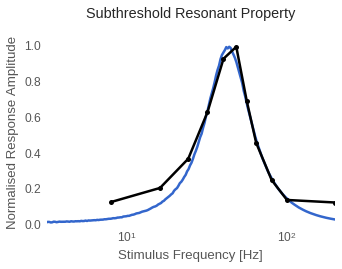

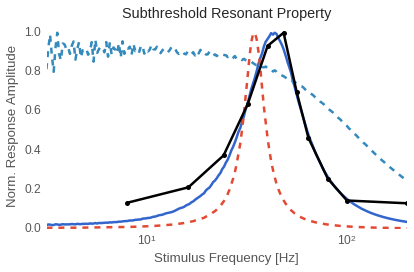

In [10]:
fontsize=14
plt.style.use(['seaborn-paper'])
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})

# matplotlib.rc('xtick', labelsize=fontsize)
# matplotlib.rc('ytick', labelsize=fontsize)
# matplotlib.rc('axes', labelsize = fontsize)
# matplotlib.rc('axes', titlesize = fontsize)
# matplotlib.rc('lines', linewidth=2)
# matplotlib.rc('axes', facecolor = "white")

plt.figure(figsize=(5,4))
plt.semilogx(F, gp/np.max(gp), label='our model', color='#3366cc')
# plt.semilogx(F, iaf/np.max(iaf), label='IAF', color="#cc3333")
# plt.semilogx(F, cc/np.max(cc), '--', label='Tchumatchenko 2014')
# plt.semilogx(F, izh/np.max(izh), '--', label='Izhikevich 2003')
plt.plot(x,y/np.max(y), 'k-', markersize=10, label='Cardin 2009 FS PV-Cre')
plt.plot(x,y/np.max(y), 'k.', markersize=10)
plt.ylim([0,1.05])
# plt.legend()
plt.xlabel('Stimulus Frequency [Hz]')
plt.ylabel('Normalised Response Amplitude')
plt.xlim([0,200])
plt.title('Subthreshold Resonant Property', y=1.08)
plt.tight_layout()
plt.savefig(PAPER+'resonance.svg')
plt.savefig(DIRECTORY+'_resonance.pdf')


plt.figure(figsize=(6,4))
plt.semilogx(F, gp/np.max(gp), label='our model', color='#3366cc')
plt.semilogx(F, cc/np.max(cc), '--', label='Tchumatchenko 2014')
plt.semilogx(F, izh/np.max(izh), '--', label='Izhikevich 2003')
plt.plot(x,y/np.max(y), 'k-', markersize=10, label='Cardin 2009 FS PV-Cre')
plt.plot(x,y/np.max(y), 'k.', markersize=10)
plt.ylim([0,1.05])
# plt.legend()
plt.xlabel('Stimulus Frequency [Hz]')
plt.ylabel('Norm. Response Amplitude')
plt.xlim([0,200])
plt.title('Subthreshold Resonant Property')
plt.tight_layout()
plt.savefig(DIRECTORY+'_resonance_suppl.pdf')

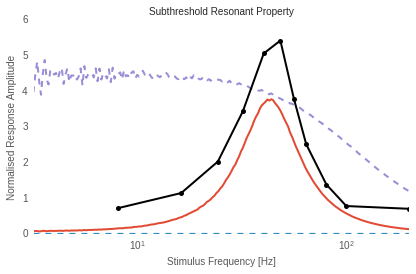

In [10]:
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})

matplotlib.rc('xtick', labelsize=10)
matplotlib.rc('ytick', labelsize=10)
matplotlib.rc('axes', labelsize = 10)
matplotlib.rc('axes', titlesize = 10)
matplotlib.rc('lines', linewidth=2)

plt.figure(figsize=(6,4))
plt.semilogx(F, gp, label='our model')
plt.semilogx(F, cc, '--', label='Tchumatchenko 2014')
plt.semilogx(F, izh, '--', label='Izhikevich 2003')
plt.plot(x,y, 'k-', markersize=10, label='Cardin 2009 FS PV-Cre')
plt.plot(x,y, 'k.', markersize=10)
# plt.ylim([0,1.05])
# plt.legend()
plt.xlabel('Stimulus Frequency [Hz]')
plt.ylabel('Normalised Response Amplitude')
plt.xlim([0,200])
plt.title('Subthreshold Resonant Property')
plt.tight_layout()
# plt.savefig(DIRECTORY+'_resonance.pdf')

In [ ]:
T = 800
dt = 0.1
t = np.arange(0,T,dt)
v = -65

fig = plt.figure(figsize=(30,8))

for i,s in enumerate([100,200,300]):
    ax = fig.add_subplot(231+i) 
    res_v = []
    res_u = []
    I = s
    c= 0
    u=0
    v = -65
    for k in t:
        v += dt/15 * ( (v+60)*(v+50) - 20*u + 8*I)
        u += dt * 0.03 * ( (v +55) - u)
        if v>25:
            v = -40
            u += 50
            c+=1
        res_v.append(v)
        res_u.append(u)
    ax.set_xticklabels([])
    ax.plot(t, res_v, label='v')
#     ax.plot(t, res_u, label='u')
    ax.legend()
    ax.set_title('Fast Spiking Cell : %g Hz| S = %d'%(float(1000*c/T),s))
    # plt.plot(t, res_u, label = 'u')

for i,s in enumerate([100,200,300]):
    ax = fig.add_subplot(234+i) 
    res_v = []
    res_u = []
    c = 0
    I = s
    u=0
    v = -65
    for i in t:
        v += dt/20 * ( (v+55)*(v+40) - u + I)
        u += dt * 0.2 * ( 0.025 * (v +55)**3*(v>-55) - u)
        if v>25:
            c += 1
            v = -45
        res_v.append(v)
        res_u.append(u)
    ax.set_xlabel('Time [0.8s]')
    ax.plot(t, res_v, label='v')
#     ax.plot(t, res_u, label='u')
    ax.legend()
    ax.set_title('Original Fast Spiking Cell freq: %g Hz | S = %d'%(float(1000*c/T),s))


plt.savefig(DIRECTORY + 'neuron_models.pdf')


In [ ]:
matplotlib.rc('xtick', labelsize=10)
matplotlib.rc('ytick', labelsize=10)
matplotlib.rc('axes', labelsize = 10)
matplotlib.rc('axes', titlesize = 10)
matplotlib.rc('lines', linewidth=2)
T = 1000
dt = 0.1
t = np.arange(0,T,dt)
v = -65

fig = plt.figure(figsize=(6,4))

#MINE
for i,s in enumerate([100,200,300]):
    ax = fig.add_subplot(231+i) 
    res_v = []
    res_u = []
    I = s
    c= 0
    u=0
    v = -65
    for j in t:
        v += dt/15 * ( (v+60)*(v+50) - 20*u + 8*I)
        u += dt * 0.03 * ( (v +55) - u)
        if v>25:
            v = -40
            u += 50
            c+=1
        res_v.append(v)
        res_u.append(u)
    ax.set_xticklabels([])
    if i==0:
        ax.set_yticks([-80,0,40])
    else:
        ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylim([-85,40])
    ax.plot(t, res_v, label='v')
    ax.set_xlim([0,100])
#     ax.plot(t, res_u, label='u')
    ax.set_title('%.3g Hz - S = %dpA'%(float(1000*c/T),s))
    # plt.plot(t, res_u, label = 'u')

#IZH
for i,s in enumerate([100,200,300]):
    ax = fig.add_subplot(234+i) 
    res_v = []
    res_u = []
    c = 0
    I = s
    u=0
    v = -65
    for j in t:
        v += dt/20 * ( (v+55)*(v+40) - u + I)
        u += dt * 0.2 * ( 0.025 * (v +55)**3*(v>-55) - u)
        if v>25:
            c += 1
            v = -45
        res_v.append(v)
        res_u.append(u)
#     ax.set_xlabel('Time [0.8s]')
    if i==0:
        ax.set_yticks([-80,0,40])
    else:
        ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_ylim([-85,40])
    ax.plot(t, res_v, label='v', color=plt.rcParams['axes.color_cycle'][2])
    ax.set_xlim([0,100])
#     ax.plot(t, res_u, label='u')
    ax.set_title('%.3g Hz - S = %dpA'%(float(1000*c/T),s))
plt.tight_layout()
plt.savefig(DIRECTORY + 'neuron_models.pdf')


In [ ]:
plt.cm.gg

In [ ]:
c = plt.cm.get_cmap()

In [ ]:
c.name